In [20]:
import sys
sys.path.append('../')

import numpy as np
import optuna
import torch
import pickle

# NDN tools
import NDNT.utils as utils # some other utilities
import NDNT.NDNT as NDN
from NDNT.modules.layers import *
from NDNT.networks import *

from ColorDataUtils.multidata_utils import MultiExperiment
from NDNT.utils import imagesc   # because I'm lazy

device = torch.device("cuda:1")
dtype = torch.float32

datadir = '/home/dbutts/ColorV1/Data/'
dirname = '/home/dbutts/ColorV1/CLRworkspace/'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load dataset

In [21]:
# load data
num_lags=16
#expt_names = ['J220715','J220722','J220801','J220808']
expt_names = ['J220718', 'J220727']
expts = MultiExperiment(expt_names)
data, drift_terms, mu0s = expts.load(datadir,
                                     num_lags=num_lags,
                                     et_metric_thresh=0.8,
                                     array_types=['LP', 'LP'],
                                     luminance_only=True)

  FILE_INFO: stim_locsLP list again -- ok but output check
  Disjoint data exists with this eye_config -- trunctating to first section.
  FILE_INFO: stim_locsLP list again -- ok but output check
  Disjoint data exists with this eye_config -- trunctating to first section.
153120 total time steps, 444 units
J220718 48.2% fixations remaining
J220727 37.7% fixations remaining
  Stim expansion for shift: [920, 500, 1012, 592]
  Writing lam stim 0: overlap 44, 35
  Writing lam stim 1: overlap 44, 57
  Writing lam stim 2: overlap 48, 57
  Writing lam stim 3: overlap 48, 35
  Adding fixation point
  Shifting stim...


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.57it/s]


  CROP: New stim size: 52 x 52
  Done: expt 0
  Stim expansion for shift: [975, 530, 1067, 622]
  Writing lam stim 0: overlap 10, 8
  Writing lam stim 1: overlap 10, 60
  Writing lam stim 2: overlap 60, 60
  Writing lam stim 3: overlap 60, 8
  Shifting stim...


100%|█████████████████████████████████████████████████████████████████████████| 11/11 [00:09<00:00,  1.21it/s]


  CROP: New stim size: 52 x 52
  Done: expt 1
Stimulus assembly complete


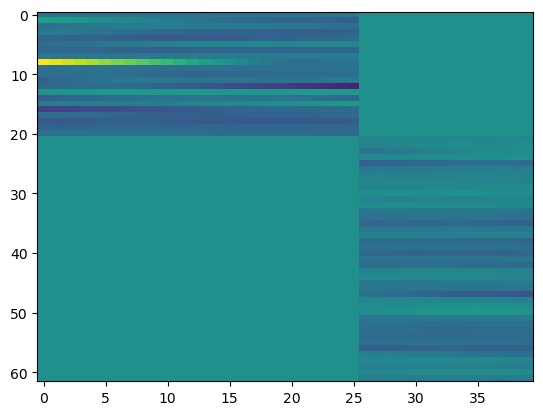

In [23]:
imagesc(drift_terms)

# adam params

In [24]:
class Model:
    def __init__(self, ndn_model, LLs, trial):
        self.ndn_model = ndn_model
        self.LLs = LLs
        self.trial = trial

adam_parsT = utils.create_optimizer_params(
    optimizer_type='AdamW',
    batch_size=2, # * 240 timesteps
    num_workers=0,
    learning_rate=0.0017,
    early_stopping_patience=4,
    optimize_graph=False,
    weight_decay=0.235,
    max_epochs=1)
adam_parsT['device'] = device
#adam_parsT['accumulated_grad_batches'] = 6

# setup
data.device = device
NCv = data.NC
NT = data.robs.shape[0]
NA = data.Xdrift.shape[1]

# model params

In [25]:
# some good starting parameters
Treg = 0.01
Xreg = 0.000001
Mreg = 0.0001
Creg = None
Dreg = 0.5

folder_name = 'models/test_core'
num_trials = 10

# define cnn model

In [36]:
def make_model_cnn(trial):
    LGNpars = STconvLayer.layer_dict(
        input_dims = data.stim_dims,
        num_filters=4,
        num_inh=2,
        bias=False,
        norm_type=1,
        filter_dims=[1,  # channels
                     7,  # width
                     7,  # height
                     14], # lags
        NLtype='relu',
        initialize_center=True)
    LGNpars['output_norm']='batch'
    LGNpars['window']='hamming'
    LGNpars['reg_vals'] = {'d2x':Xreg,
                           'd2t':Treg,
                           'center': Creg, # None
                           'edge_t':100} # just pushes the edge to be sharper

    num_subs0 = trial.suggest_int('num_subs_l0', 20, 80)
    num_subs1 = trial.suggest_int('num_subs_l1', 20, 80)
    num_subs2 = trial.suggest_int('num_subs_l2', 20, 80)
    num_inh0 = trial.suggest_float('num_inh_l0', 0.1, 0.7)
    num_inh1 = trial.suggest_float('num_inh_l1', 0.1, 0.7)
    num_inh2 = trial.suggest_float('num_inh_l2', 0.1, 0.7)
    conv_l0_filter_width = trial.suggest_int('conv_l0_filter_width', 7, 39, step=2)
    conv_l1_filter_width = trial.suggest_int('conv_l1_filter_width', 5, 39, step=2)
    conv_l2_filter_width = trial.suggest_int('conv_l2_filter_width', 3, 39, step=2)

    proj_pars = ConvLayer.layer_dict(
        num_filters=num_subs0,
        bias=False,
        norm_type=1,
        num_inh=int(num_inh0*num_subs0),
        filter_dims=trial.suggest_int('proj_filter_width', 7, 29, step=2),
        NLtype=trial.suggest_categorical('proj_NLtype', ['lin', 'relu']),
        initialize_center=True)
    proj_pars['output_norm']='batch'
    proj_pars['window']='hamming'

    conv_layer0 = ConvLayer.layer_dict(
        num_filters=num_subs0,
        num_inh=int(num_inh0*num_subs0),
        bias=False,
        norm_type=1,
        filter_dims=conv_l0_filter_width,
        NLtype='relu',
        initialize_center=False)
    conv_layer0['output_norm'] = 'batch'

    conv_layer1 = ConvLayer.layer_dict(
        num_filters=num_subs1,
        num_inh=int(num_inh1*num_subs1),
        bias=False,
        norm_type=1,
        filter_dims=conv_l1_filter_width,
        NLtype='relu',
        initialize_center=False)
    conv_layer1['output_norm'] = 'batch'

    conv_layer2 = ConvLayer.layer_dict(
        num_filters=num_subs2,
        num_inh=int(num_inh2*num_subs2),
        bias=False,
        norm_type=1,
        filter_dims=conv_l2_filter_width,
        NLtype='relu',
        initialize_center=False)
    conv_layer2['output_norm'] = 'batch'
    
    scaffold_net =  FFnetwork.ffnet_dict(
        ffnet_type='scaffold',
        xstim_n='stim',
        layer_list=[LGNpars, proj_pars, conv_layer0, conv_layer1, conv_layer2],
        scaffold_levels=[1,2])
    
    ## 1: READOUT
    # reads out from a specific location in the scaffold network
    # this location is specified by the mus
    readout_pars = ReadoutLayer.layer_dict(
        num_filters=NCv,
        NLtype='lin',
        bias=False,
        pos_constraint=True)
    # for defining how to sample from the mu (location) of the receptive field
    readout_pars['gauss_type'] = 'isotropic'
    readout_pars['reg_vals'] = {'max': Mreg}
    
    readout_net = FFnetwork.ffnet_dict(
        xstim_n = None,
        ffnet_n=[0],
        layer_list = [readout_pars],
        ffnet_type='readout')
    
    ## 2: DRIFT
    drift_pars = NDNLayer.layer_dict(
        input_dims=[1,1,1,NA],
        num_filters=NCv,
        bias=False,
        norm_type=0,
        NLtype='lin')
    drift_pars['reg_vals'] = {'d2t': Dreg}
    
    drift_net = FFnetwork.ffnet_dict(xstim_n = 'Xdrift', layer_list = [drift_pars])
    
    ## 3: COMB 
    comb_layer = ChannelLayer.layer_dict(
        num_filters=NCv,
        NLtype='softplus',
        bias=True)
    comb_layer['weights_initializer'] = 'ones'
    
    comb_net = FFnetwork.ffnet_dict(
        xstim_n = None,
        ffnet_n=[1,2],
        layer_list=[comb_layer],
        ffnet_type='add')
    
    cnn = NDN.NDN(ffnet_list = [scaffold_net, readout_net, drift_net, comb_net],
                  loss_type='poisson')
    cnn.block_sample = True
    
    ## Network 1: readout: fixed mus / sigmas
    cnn.networks[1].layers[0].sample = False
    # mus and sigmas are the centers and "widths" of the receptive field center to start at
    cnn.networks[1].layers[0].mu.data = torch.tensor(mu0s, dtype=torch.float32)
    cnn.networks[1].set_parameters(val=False, name='mu')
    cnn.networks[1].set_parameters(val=False, name='sigma')
    
    ## Network 2: drift: not fit
    cnn.networks[2].layers[0].weight.data = torch.tensor(drift_terms, dtype=torch.float32)
    cnn.networks[2].set_parameters(val=False)
    
    ## Network 3: Comb
    cnn.networks[-1].set_parameters(val=False, name='weight')

    return cnn


def objective_cnn(trial):
    cnn = make_model_cnn(trial)

    cnn.fit(data, **adam_parsT, verbose=2)
    LLs = cnn.eval_models(data, data_inds=data.val_blks, batch_size=5)

    null_adjusted_LLs = expts.LLsNULL-LLs

    cnn_model = Model(cnn, null_adjusted_LLs, trial)

    with open(folder_name+'/cnn_'+str(trial.number)+'.pkl', 'wb') as f:
        pickle.dump(cnn_model, f)

    # dump the intermediate study, but this will be off by one trial
    with open(folder_name+'/study.pkl', 'wb') as f:
        pickle.dump(study, f)

    return np.mean(null_adjusted_LLs)

In [35]:
from ColorDataUtils.model_validation import validate_model, MockTrial

val_map = {
    'proj_NLtype': 'relu',
    'proj_filter_width': 15,
    'conv_l0_filter_width': 15,
    'conv_l1_filter_width': 15,
    'conv_l2_filter_width': 15,
    'num_subs_l0': 45,
    'num_subs_l1': 30,
    'num_subs_l2': 15,
    'num_inh_l0': 0.4,
    'num_inh_l1': 0.4,
    'num_inh_l2': 0.4
}

mock_trial = MockTrial(val_map)
model = make_model_cnn(mock_trial)

validate_model(model)

Model passed all checks


# define iter model

In [31]:
def make_model_iter(trial):
    LGNpars = STconvLayer.layer_dict(
        input_dims = data.stim_dims,
        num_filters=4,
        num_inh=2,
        bias=False,
        norm_type=1,
        filter_dims=[1,  # channels
                     7,  # width
                     7,  # height
                     14], # lags
        NLtype='relu',
        initialize_center=True)
    LGNpars['output_norm']='batch'
    LGNpars['window']='hamming'
    LGNpars['reg_vals'] = {'d2x':Xreg,
                           'd2t':Treg,
                           'center': Creg, # None
                           'edge_t':100} # just pushes the edge to be sharper
    
    num_subs = trial.suggest_int('num_subs', 10, 50)
    num_inh = trial.suggest_float('num_inh', 0.1, 0.7)
    proj_pars = ConvLayer.layer_dict(
        num_filters=num_subs,
        bias=False,
        norm_type=1,
        num_inh=int(num_inh*num_subs),
        filter_dims=trial.suggest_int('proj_filter_width', 7, 29, step=2),
        NLtype=trial.suggest_categorical('proj_NLtype', ['lin', 'relu']),
        initialize_center=True)
    proj_pars['output_norm']='batch'
    proj_pars['window']='hamming'
    
    iter_layer = IterLayer.layer_dict(
        num_filters=num_subs,
        num_inh=int(num_inh*num_subs),
        bias=False,
        num_iter=trial.suggest_int('num_iter', 2, 8),
        output_config='full',
        norm_type=1,
        filter_width=trial.suggest_int('iter_filter_width', 7, 47, step=2),
        num_lags=2,
        NLtype='relu',
        initialize_center=False,
        res_layer=False)
    iter_layer['output_norm'] = 'batch'
    
    scaffold_net =  FFnetwork.ffnet_dict(
        ffnet_type='scaffold',
        xstim_n='stim',
        layer_list=[LGNpars, proj_pars, iter_layer],
        scaffold_levels=[1,2])
    
    ## 1: READOUT
    # reads out from a specific location in the scaffold network
    # this location is specified by the mus
    readout_pars = ReadoutLayer.layer_dict(
        num_filters=NCv,
        NLtype='lin',
        bias=False,
        pos_constraint=True)
    # for defining how to sample from the mu (location) of the receptive field
    readout_pars['gauss_type'] = 'isotropic'
    readout_pars['reg_vals'] = {'max': Mreg}
    
    readout_net = FFnetwork.ffnet_dict(
        xstim_n = None,
        ffnet_n=[0],
        layer_list = [readout_pars],
        ffnet_type='readout')
    
    ## 2: DRIFT
    drift_pars = NDNLayer.layer_dict(
        input_dims=[1,1,1,NA],
        num_filters=NCv,
        bias=False,
        norm_type=0,
        NLtype='lin')
    drift_pars['reg_vals'] = {'d2t': Dreg}
    
    drift_net = FFnetwork.ffnet_dict(xstim_n = 'Xdrift', layer_list = [drift_pars])
    
    ## 3: COMB 
    comb_layer = ChannelLayer.layer_dict(
        num_filters=NCv,
        NLtype='softplus',
        bias=True)
    comb_layer['weights_initializer'] = 'ones'
    
    comb_net = FFnetwork.ffnet_dict(
        xstim_n = None,
        ffnet_n=[1,2],
        layer_list=[comb_layer],
        ffnet_type='add')
    
    cnn = NDN.NDN(ffnet_list = [scaffold_net, readout_net, drift_net, comb_net],
                  loss_type='poisson')
    cnn.block_sample = True
    
    ## Network 1: readout: fixed mus / sigmas
    cnn.networks[1].layers[0].sample = False
    # mus and sigmas are the centers and "widths" of the receptive field center to start at
    cnn.networks[1].layers[0].mu.data = torch.tensor(mu0s, dtype=torch.float32)
    cnn.networks[1].set_parameters(val=False, name='mu')
    cnn.networks[1].set_parameters(val=False, name='sigma')
    
    ## Network 2: drift: not fit
    cnn.networks[2].layers[0].weight.data = torch.tensor(drift_terms, dtype=torch.float32)
    cnn.networks[2].set_parameters(val=False)
    
    ## Network 3: Comb
    cnn.networks[-1].set_parameters(val=False, name='weight')

    return cnn


def objective_iter(trial):
    cnn = make_model_iter(trial)

    cnn.fit(data, **adam_parsT, verbose=2)
    LLs = cnn.eval_models(data, data_inds=data.val_blks, batch_size=5)

    null_adjusted_LLs = expts.LLsNULL-LLs

    cnn_model = Model(cnn, null_adjusted_LLs, trial)

    with open(folder_name+'/cnn_'+str(trial.number)+'.pkl', 'wb') as f:
        pickle.dump(cnn_model, f)

    # dump the intermediate study, but this will be off by one trial
    with open(folder_name+'/study.pkl', 'wb') as f:
        pickle.dump(study, f)

    return np.mean(null_adjusted_LLs)

# run study

In [32]:
from ColorDataUtils.model_validation import validate_model, MockTrial

val_map = {
    'iter_filter_width': 15,
    'num_inh': 0.69,
    'num_iter': 7,
    'num_subs': 45,
    'proj_NLtype': 'relu',
    'proj_filter_width': 15,
}

mock_trial = MockTrial(val_map)
model = make_model_iter(mock_trial)

validate_model(model)

Model passed all checks


In [33]:
# create study
study = optuna.create_study(direction='maximize',
                            study_name='Four datasets w/o initializing LGN weights')

# enqueue initial parameters
study.enqueue_trial(val_map)

# run the study
from cProfile import Profile
from pstats import SortKey, Stats

with Profile() as profile:
    print(f"{study.optimize(objective_iter, n_trials=1) = }")
    (
        Stats(profile)
        .strip_dirs()
        .sort_stats(SortKey.CALLS)
        .print_stats()
    )

# dump the final study
with open(folder_name+'/study.pkl', 'wb') as f:
    pickle.dump(study, f)

# print the best trial
print(study.best_trial.number, study.best_params)

[I 2023-08-17 18:07:46,580] A new study created in memory with name: Four datasets w/o initializing LGN weights


Model: M062_CsCX_R_N_A

GPU Available: True, GPU Used: True


Epoch 1:   2%|█                                             | 6/255 [00:08<06:05,  1.47s/it, train_loss=0.294]


Done fitting
  Fit complete: 11.28059196472168 sec elapsed


Eval models:   0%|                                                                     | 0/26 [00:05<?, ?it/s]
[W 2023-08-17 18:08:03,273] Trial 0 failed with parameters: {'num_subs': 45, 'num_inh': 0.69, 'proj_filter_width': 15, 'proj_NLtype': 'relu', 'num_iter': 7, 'iter_filter_width': 15} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/mattjac/anaconda3/envs/pytorch2/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_4021331/2926880145.py", line 121, in objective_iter
    LLs = cnn.eval_models(data, data_inds=data.val_blks, batch_size=5)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mattjac/projects/mattjac/v1/coremodel/../NDNT/NDNT.py", line 782, in eval_models
    pred = self(data_sample)
           ^^^^^^^^^^^^^^^^^
  File "/home/mattjac/anaconda3/envs/pytorch2/lib/pyth

KeyboardInterrupt: 